Training PyTorch model with SGD...
Training PyTorch model with SGD+Momentum...
Training PyTorch model with SGD+Nesterov...
Training PyTorch model with Adagrad...
Training PyTorch model with RMSprop...
Training PyTorch model with Adam...
Training TensorFlow model with SGD...


/Users/aleksandr/Desktop/itmo/s4/optimisation-methods/Stochastic-Gradient-Descent/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/var/folders/90/4001hvgn0m31_pyw0p80brbr0000gn/T/ipykernel_74139/1672858523.py:156: RuntimeWarning: overflow encountered in square
  train_losses.append(np.mean((tr_pred - y_train.numpy())**2))


Training TensorFlow model with SGD+Momentum...


/Users/aleksandr/Desktop/itmo/s4/optimisation-methods/Stochastic-Gradient-Descent/.venv/lib/python3.11/site-packages/numpy/_core/_methods.py:136: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/var/folders/90/4001hvgn0m31_pyw0p80brbr0000gn/T/ipykernel_74139/1672858523.py:157: RuntimeWarning: overflow encountered in square
  test_losses.append( np.mean((te_pred - y_test.numpy())**2) )


Training TensorFlow model with SGD+Nesterov...
Training TensorFlow model with Adagrad...
Training TensorFlow model with RMSprop...
Training TensorFlow model with Adam...


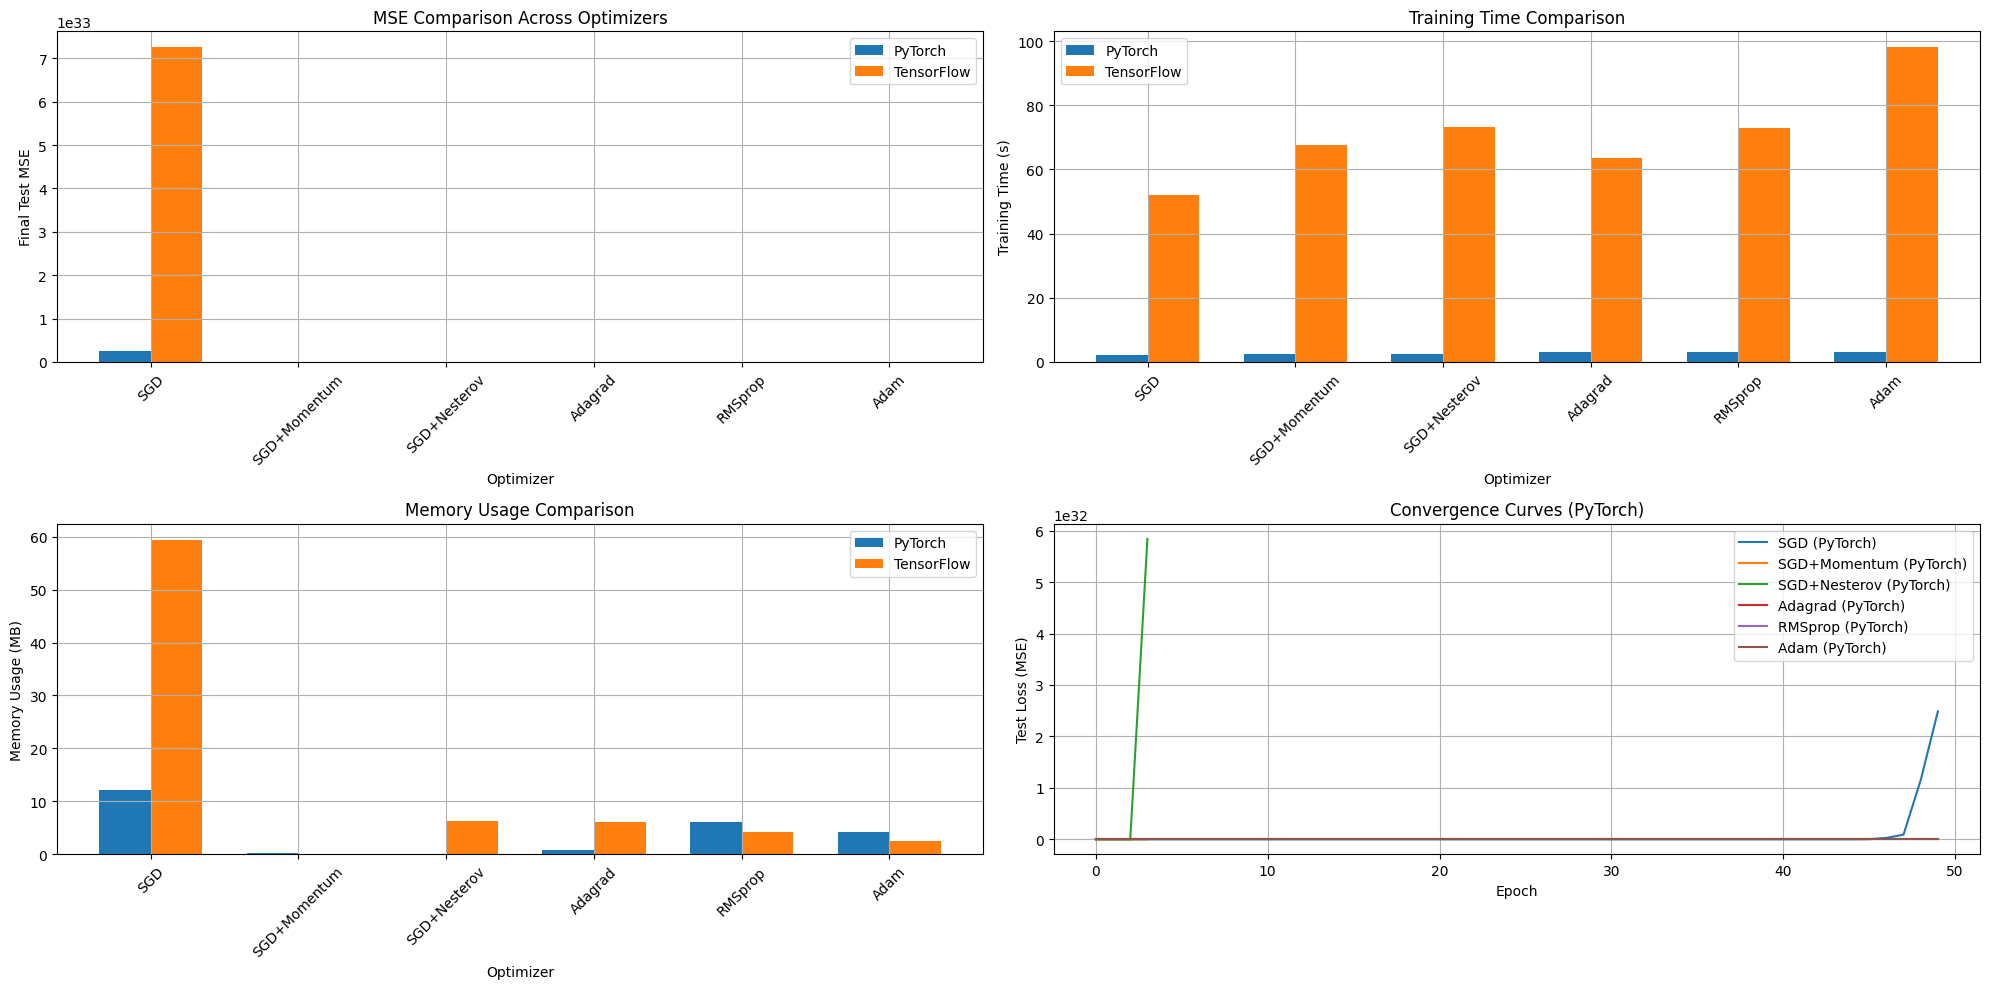

Optimization Comparison Results:
--------------------------------------------------------------------------------
Optimizer       Framework    Final MSE    Training Time   Memory (MB) 
--------------------------------------------------------------------------------
SGD             PyTorch      248720626278956608761023566970880.000000 2.206486s 12.08
SGD+Momentum    PyTorch      nan 2.327077s 0.33
SGD+Nesterov    PyTorch      nan 2.360840s 0.09
Adagrad         PyTorch      0.567478 3.007346s 0.84
RMSprop         PyTorch      0.547425 2.915492s 6.02
Adam            PyTorch      0.558680 3.057436s 4.16
SGD             TensorFlow   7262143126710317373894168674304000.000000 52.097649s 59.44
SGD+Momentum    TensorFlow   nan 67.610205s 0.00
SGD+Nesterov    TensorFlow   nan 73.260332s 6.30
Adagrad         TensorFlow   0.622614 63.501442s 6.12
RMSprop         TensorFlow   0.637064 72.996225s 4.25
Adam            TensorFlow   0.549358 98.135833s 2.59


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
from tensorflow import keras
from keras.losses import mean_squared_error
from src.data import load_california
import time
import psutil

# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
tf.random.set_seed(42)

# Load and prepare data
X, y = load_california(scale=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Convert to tensors for PyTorch
X_train_torch = torch.FloatTensor(X_train)
y_train_torch = torch.FloatTensor(y_train.reshape(-1, 1))
X_test_torch  = torch.FloatTensor(X_test)
y_test_torch  = torch.FloatTensor(y_test.reshape(-1, 1))

# Convert to tensors for TensorFlow
X_train_tf = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train_tf = tf.convert_to_tensor(y_train.reshape(-1, 1), dtype=tf.float32)
X_test_tf  = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test_tf  = tf.convert_to_tensor(y_test.reshape(-1, 1), dtype=tf.float32)

# Common parameters
epochs = 50
batch_size = 32
learning_rate = 0.01

# PyTorch model
class LinearRegressionTorch(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)
    def forward(self, x):
        return self.linear(x)

def train_torch_model(optimizer_name, X_train, y_train, X_test, y_test):
    model = LinearRegressionTorch(X_train.shape[1])
    criterion = nn.MSELoss()
    # select optimizer
    if optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    elif optimizer_name == "SGD+Momentum":
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    elif optimizer_name == "SGD+Nesterov":
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
    elif optimizer_name == "Adagrad":
        optimizer = optim.Adagrad(model.parameters(), lr=learning_rate)
    elif optimizer_name == "RMSprop":
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
    elif optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    proc = psutil.Process()
    mem_before = proc.memory_info().rss
    mem_peak = mem_before

    start_time = time.time()

    train_losses, test_losses = [], []
    for epoch in range(epochs):
        # mini-batch training
        idx = torch.randperm(len(X_train))
        for i in range(0, len(X_train), batch_size):
            bi = idx[i:i+batch_size]
            preds = model(X_train[bi])
            loss = criterion(preds, y_train[bi])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # record losses
        with torch.no_grad():
            train_losses.append(criterion(model(X_train), y_train).item())
            test_losses.append( criterion(model(X_test),  y_test ).item())

        # update peak memory
        current_rss = proc.memory_info().rss
        if current_rss > mem_peak:
            mem_peak = current_rss

    training_time = time.time() - start_time
    memory_used = mem_peak - mem_before

    # final MSE
    with torch.no_grad():
        final_mse = criterion(model(X_test), y_test).item()

    return {
        'optimizer': optimizer_name,
        'framework': 'PyTorch',
        'final_mse': final_mse,
        'train_losses': train_losses,
        'test_losses': test_losses,
        'training_time': training_time,
        'memory_used': memory_used
    }

# TensorFlow model
def create_tf_model(input_dim):
    return keras.Sequential([ keras.layers.Dense(1, input_shape=(input_dim,)) ])

def train_tf_model(optimizer_name, X_train, y_train, X_test, y_test):
    model = create_tf_model(X_train.shape[1])
    # select optimizer
    if optimizer_name == "SGD":
        opt = keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer_name == "SGD+Momentum":
        opt = keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    elif optimizer_name == "SGD+Nesterov":
        opt = keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)
    elif optimizer_name == "Adagrad":
        opt = keras.optimizers.Adagrad(learning_rate=learning_rate)
    elif optimizer_name == "RMSprop":
        opt = keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer_name == "Adam":
        opt = keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(optimizer=opt, loss='mse')

    proc = psutil.Process()
    mem_before = proc.memory_info().rss
    mem_peak = mem_before

    start_time = time.time()

    train_losses, test_losses = [], []
    for epoch in range(epochs):
        # shuffle and batch manually
        idx = np.random.permutation(len(X_train))
        Xs, ys = X_train.numpy()[idx], y_train.numpy()[idx]
        for i in range(0, len(Xs), batch_size):
            xb, yb = Xs[i:i+batch_size], ys[i:i+batch_size]
            with tf.GradientTape() as tape:
                preds = model(xb, training=True)
                loss = tf.reduce_mean(mean_squared_error(yb, preds))
            grads = tape.gradient(loss, model.trainable_variables)
            opt.apply_gradients(zip(grads, model.trainable_variables))

        # record losses
        tr_pred = model.predict(X_train, verbose=0)
        te_pred = model.predict(X_test,  verbose=0)
        train_losses.append(np.mean((tr_pred - y_train.numpy())**2))
        test_losses.append( np.mean((te_pred - y_test.numpy())**2) )

        # update peak memory
        current_rss = proc.memory_info().rss
        if current_rss > mem_peak:
            mem_peak = current_rss

    training_time = time.time() - start_time
    memory_used = mem_peak - mem_before

    final_pred = model.predict(X_test, verbose=0)
    final_mse  = np.mean((final_pred - y_test.numpy())**2)

    return {
        'optimizer': optimizer_name,
        'framework': 'TensorFlow',
        'final_mse': final_mse,
        'train_losses': train_losses,
        'test_losses': test_losses,
        'training_time': training_time,
        'memory_used': memory_used
    }

# Run experiments as before...


# Run experiments
optimizers = ["SGD", "SGD+Momentum", "SGD+Nesterov", "Adagrad", "RMSprop", "Adam"]
results = []

# PyTorch experiments
for opt in optimizers:
    print(f"Training PyTorch model with {opt}...")
    result = train_torch_model(opt, X_train_torch, y_train_torch, X_test_torch, y_test_torch)
    results.append(result)

# TensorFlow experiments
for opt in optimizers:
    print(f"Training TensorFlow model with {opt}...")
    result = train_tf_model(opt, X_train_tf, y_train_tf, X_test_tf, y_test_tf)
    results.append(result)

# Plot results
def plot_optimization_comparison(results):
    plt.figure(figsize=(20, 10))

    # Plot 1: MSE comparison
    plt.subplot(2, 2, 1)
    torch_results = [r for r in results if r['framework'] == 'PyTorch']
    tf_results = [r for r in results if r['framework'] == 'TensorFlow']

    opt_names = [r['optimizer'] for r in torch_results]
    torch_mse = [r['final_mse'] for r in torch_results]
    tf_mse = [r['final_mse'] for r in tf_results]

    x = np.arange(len(opt_names))
    width = 0.35

    plt.bar(x - width/2, torch_mse, width, label='PyTorch')
    plt.bar(x + width/2, tf_mse, width, label='TensorFlow')
    plt.xlabel('Optimizer')
    plt.ylabel('Final Test MSE')
    plt.title('MSE Comparison Across Optimizers')
    plt.xticks(x, opt_names, rotation=45)
    plt.legend()
    plt.grid(True)

    # Plot 2: Training time comparison
    plt.subplot(2, 2, 2)
    torch_time = [r['training_time'] for r in torch_results]
    tf_time = [r['training_time'] for r in tf_results]

    plt.bar(x - width/2, torch_time, width, label='PyTorch')
    plt.bar(x + width/2, tf_time, width, label='TensorFlow')
    plt.xlabel('Optimizer')
    plt.ylabel('Training Time (s)')
    plt.title('Training Time Comparison')
    plt.xticks(x, opt_names, rotation=45)
    plt.legend()
    plt.grid(True)

    # Plot 3: Memory usage comparison
    plt.subplot(2, 2, 3)
    torch_mem = [r['memory_used']/1024/1024 for r in torch_results]  # Convert to MB
    tf_mem = [r['memory_used']/1024/1024 for r in tf_results]  # Convert to MB

    plt.bar(x - width/2, torch_mem, width, label='PyTorch')
    plt.bar(x + width/2, tf_mem, width, label='TensorFlow')
    plt.xlabel('Optimizer')
    plt.ylabel('Memory Usage (MB)')
    plt.title('Memory Usage Comparison')
    plt.xticks(x, opt_names, rotation=45)
    plt.legend()
    plt.grid(True)

    # Plot 4: Convergence curves (only for first PyTorch optimizer to avoid clutter)
    plt.subplot(2, 2, 4)
    for i, r in enumerate(torch_results):
        plt.plot(r['test_losses'], label=f"{r['optimizer']} (PyTorch)")
    plt.xlabel('Epoch')
    plt.ylabel('Test Loss (MSE)')
    plt.title('Convergence Curves (PyTorch)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Display results
plot_optimization_comparison(results)

# Create a detailed comparison table
def print_comparison_table(results):
    print("Optimization Comparison Results:")
    print("-" * 80)
    print(f"{'Optimizer':<15} {'Framework':<12} {'Final MSE':<12} {'Training Time':<15} {'Memory (MB)':<12}")
    print("-" * 80)

    for r in results:
        print(f"{r['optimizer']:<15} {r['framework']:<12} {r['final_mse']:.6f} {r['training_time']:.6f}s {r['memory_used']/1024/1024:.2f}")

print_comparison_table(results)